**Project 5**

**@ScottPenberthy, February 2017**

We seek to identify cars (obstacles) on the road using computer vision techniques.  We take only pixels as input.  Our job is to find cars and identify them by drawing boxes on the video stream.  We start with static pictures and work our way up.

This notebook documents that journey.

** Introduction **

Let's begin by importing our code from the Lane Finder project and loading up a test image, then viewing it.

This code requires that the ["Vehicle Detection"](https://github.com/udacity/CarND-Vehicle-Detection) github be repo be a peer subdirectory,
located at ../CarND-Vehicle-Detection/.  

I have replicated both the Udacity project as well as all training examples in my own [CarND-Vehicle-Detection repository](https://github.com/drscott173/CarND-Vehicle-Detection) for convenience.  Download this and place it in a sister directory to this repo, accessible at ../CarND-Vehicle-Detection.


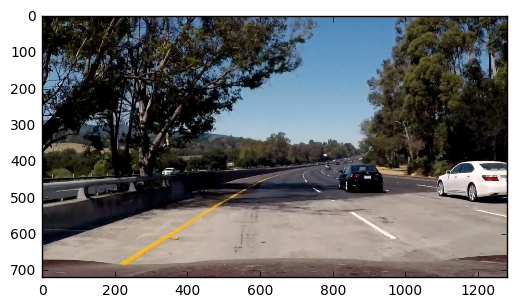

In [1]:
import lanefinder as lf
import matplotlib.pyplot as plt
%matplotlib inline

g = lf.Globals()
i4 = lf.ImageLoader("../CarND-Vehicle-Detection/test_images/test5.jpg")
plt.imshow(i4.rgb)


Let's scan the sample images for vehicles and non-vehicles, which we grabbed from the Udacity website and stored in the [CarND-Vehicle-Detection's](https://github.com/udacity/CarND-Vehicle-Detection) 'train' directory.  Print out the count of vehicles and non-vehicles seen in recursive subdirectories.

In [2]:
from lesson_functions import *
import glob

non_car_path = "../CarND-Vehicle-Detection/train/non-vehicles/"
car_path = "../CarND-Vehicle-Detection/train/vehicles/"
non_cars = glob.glob(non_car_path+"/*/*.png")
cars = glob.glob(car_path+"/*/*.png")
print("Found ", len(cars), "cars and", len(non_cars), "'non-cars'")

Found  8792 cars and 8968 'non-cars'


Good!  Our set is relatively well balanced.  

We now introduce image augmentation tricks.  We do this to avoid over-fitting. These techniques were helpful in deep learning.  We randomly introduce shadows,
variations in brightness, translations in x and y, and perhaps flipping left to right.


In [322]:
#
# Let's borrow our image augmentation routines that we used
# when training a deep learning network to clone our driving 
# behavior.
#

def bgr2hls(img):
    img2 = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    return img2

def hls2bgr(img):
    img1 = cv2.cvtColor(img, cv2.COLOR_HLS2BGR)
    return img1

def bgr2hsv(img):
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img1

def hsv2bgr(img):
    img1 = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img1

def add_random_shadow(image):
    #
    # Add a random shadow to a BGR image to pretend
    # we've got clouds or other interference on the road.
    #
    rows,cols,_ = image.shape
    top_y = cols*np.random.uniform()
    top_x = 0
    bot_x = rows
    bot_y = cols*np.random.uniform()
    image_hls = bgr2hls(image)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y)-(bot_x - top_x)*(Y_m-top_y) >=0)] = 1
    random_bright = .25+.7*np.random.uniform()
    if (np.random.randint(2) ==1 ):
        random_bright = .5
        cond1 = (shadow_mask==1)
        cond0 = (shadow_mask==0)
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright 
    image = hls2bgr(image_hls)   
    return image

def augment_brightness_camera_images(image):
    #
    # expects input image as BGR, adjusts brightness to 
    # pretend we're in different lighting conditions.
    #
    image1 = bgr2hsv(image)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image2 = hsv2bgr(image1)
    return image2

def trans_image(img, trans_range):
    # 
    # Shift image up or down a bit within trans_range pixels,
    # filling missing area with black.  IMG is in BGR format.
    #
    rows, cols, _ = img.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    img_tr = cv2.warpAffine(img,Trans_M,(cols,rows))
    return img_tr

def augment_image(path):
    # 
    # We "augment" an image at path and return it in RGB space
    #
    img_data = cv2.imread(path).astype('uint8')
    img = augment_brightness_camera_images(img_data)
    if (np.random.randint(4) == 0):
        img_shadows = add_random_shadow(img)
        img_tr = trans_image(img_shadows, 16)
        img = img_tr
        if (np.random.randint(2) == 0):
            img = cv2.flip(img_tr,1)
            
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Let's grab a random car image and see what the augmented version looks like, testing the code.

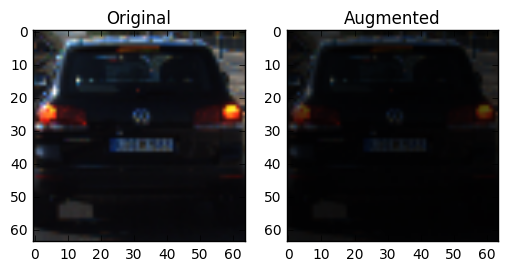

In [380]:
import random

car = random.choice(cars)
orig = cv2.cvtColor(cv2.imread(car), cv2.COLOR_BGR2RGB)
img = augment_image(car)

fig = plt.figure()
fig.add_subplot(121)
plt.title("Original")
plt.imshow(orig)
fig.add_subplot(122)
plt.title("Augmented")
plt.imshow(img)

Looks great! Let's now try this with our "non-car" images from background scenery.

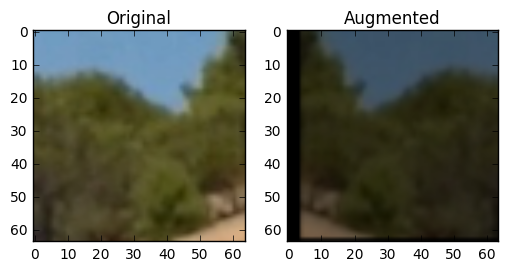

In [381]:
other = random.choice(non_cars)

orig2 = cv2.cvtColor(cv2.imread(other), cv2.COLOR_BGR2RGB)
img2 = augment_image(other)

fig = plt.figure()
fig.add_subplot(121)
plt.title("Original")
plt.imshow(orig2)
fig.add_subplot(122)
plt.title("Augmented")
plt.imshow(img2)

**Histogram of Gradients (HOG)**

We borrow code from Udacity for creating feature vectors from images.  These vectors simply compress the image into a "spatial size," then unwrap the image into a single, long vector of color values.  We append to this an instagram of color values separated into 'hist_bins' bins.  We then append a histogram of gradients, which we bucket into 9 different angles.

Note that our vector is relatively small.  We reduce an image to roughly 500 numbers, first a compressed 8x8 block of colors, then a histogram of colors from the whole image taken into just 16 buckets, and finally a histogram of gradients with 9 angle "buckets."

We experimented with multiple settings.  At one point, our feature vector was thousands of numbers long with a 32x32 spatial size, 8 pixels per cell for HOG analysis, 32 histogram bins of color.  Accuracy only bumped a few points while computation skyrocketed.  We decided to ease back to a computationally cheap setting that gave decent results at 95%, then use heuristics to improve the pipeline by examining frame to frame in video.

In [343]:
def hog(path):
    img = augment_image(path)
    return my_features(img)
    
def my_features(img):
    feat = single_img_features(img, 
                               color_space='YUV',
                               spatial_size=(8,8),
                               hist_bins=16,
                               orient=9,
                               pix_per_cell=16,
                               cell_per_block=2,
                               hog_channel=0)
    return feat

f1 = hog(random.choice(cars))
print("Our feature vector has", len(f1), "elements.")
    

Our feature vector has 564 elements.


We create a set of car features by reading in all our car images, randomly augmenting the image, then calculating the ~500-element feature vector as above.  We do the same for non-car images.

This takes a while, so print out progress after each chunk of images are done.

In [344]:
#
# Build feature vectors
#

print("Analyzing cars")
car_features = [hog(car) for car in cars]

print("Analyzing non-cars")
noncar_features = [hog(other) for other in non_cars]

print("Feature extraction now complete.")


Analyzing cars
Analyzing non-cars
Feature extraction now complete.


Stack these feature vectors into a vertical pile. That becomes our set of features X for machine learning. Assign a "1" label to all cars and a "0" label to all others and stack these in a column, one number per feature vector.   That becomes our labels y for machine learning.

Separate X, y into a training and test set, pulling random sets such that we reserve 20% of our examples for testing, 80% for training.


In [345]:
#
# Turn features into X,y for a classifier
#

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
rand_state = np.random.randint(0,100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("Training set complete with ",len(X_train)," samples")


Training set complete with  14208  samples


** Training a classifier **

Train a support vector machine to separate the 500-dimensional space the best it can.  With the relatively small feature size of ~500 we still get 95 percent accuracy. I found that this is more than good enough.  We'll use multiple window sizes, each of which will vote for an area of the image. Overlay enough of these, the 95% algorithm gives us much better accuracy! This was a nice tradeoff between speed and performance.


In [346]:
#
# Train & test a classifier
#
import time

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

7.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9586


** Sliding Window Search **

We see that the classifier does a decent, though not perfect, job of identifying cars at 96% accuracy.

We find cars by picking a window size, say a 32x32 square, and sliding this from left to right, from the top to the bottom over our image.  We run our classifier at each position.  If we get a hit, we remember this area as a "hot window."  This gives us a set of candiate image areas for cars.

Images from the forwad-facing car camera capture perspective.  Cars and objects on the horizon, near the middle of the image, will appear small. Objects closer to us at the bottom of the image will appear larger.  We tesselate the image with fine-grained windows at the middle, then increase the window size as we go lower in the image.  We also overlap the window bands for redundancy, allowing for offset problems where we accidentally capture only a fraction of a car in our sliding technique.

We divide the window into multiple bands (win_1 to win_4) in the code below, each of which has a few set of windows.  We start with a top band on the horizon with the smallest 32x32 window.  The next band steps down a bit, using a wider aperture of 40x40.  We repeat this for 64x64 and 80x80 window sizes.  We stack and restric these windows to form a perspective pyramid.


Image size (360, 640, 3)
72 66 42
Detected in  0.34363389015197754 seconds
Found  24 windows


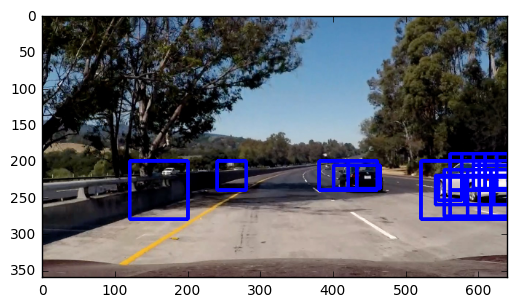

In [356]:
#
# Check our performance
#

def find_cars(img, windows, clf, scaler):
    car_windows = []
    for window in windows:
        #3) Extract the test window from original image
        #print("Scan ", window)
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (64, 64),  interpolation = cv2.INTER_AREA)      
        features = my_features(test_img)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        if clf.predict(test_features) == 1:
            car_windows.append(window)
    return car_windows

t=time.time()
image = cv2.resize(np.copy(i4.rgb), (640, 360), interpolation = cv2.INTER_AREA)
print("Image size", image.shape)
draw_image = cv2.resize(np.copy(i4.rgb), (640, 360), interpolation = cv2.INTER_AREA)
xy=(0.5, 0.5)
win1 = slide_window(image, x_start_stop=[240, None], y_start_stop=[190, 265],  
                        xy_window=(32, 32), xy_overlap=xy)
win2 = slide_window(image, x_start_stop=[180, None], y_start_stop=[180, 260],  
                        xy_window=(40, 40), xy_overlap=xy)
win3 = slide_window(image, x_start_stop=[200, 700], y_start_stop=[180, 320],  
                    xy_window=(64, 64), xy_overlap=xy)
win4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[200, 320],  
                    xy_window=(80, 80), xy_overlap=xy)
print(len(win1), len(win2), len(win3))
#if win1 is None:
#    win1 = []
#if (len(win2) > 0):
#    win1.append(win2)
#if (len(win3) > 0):
#    win1.append(win3)

windows = win1+win2+win3+win4
hot_windows = find_cars(image, windows, svc, X_scaler)
t2 = time.time()
print("Detected in ",t2-t, "seconds")
print("Found ", len(hot_windows), "windows")
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)  
#window_img = draw_boxes(window_img, win2, color=(256, 256, 0), thick=1) 
#window_img = draw_boxes(window_img, win3, color=(256, 256, 0), thick=1) 
#window_img = draw_boxes(window_img, win3, color=(200, 200, 0), thick=1) 
#window_img = draw_boxes(window_img, win4, color=(256, 256, 0), thick=1)
plt.imshow(window_img)


** Video Implementation **

We first evaluated a video one frame at a time, then animated results.  In this phase we don't do any processing between frames.  Instead, we just watch the boxes over time, driving our own intuition about what the inter-frame heuristics need to eliminate.

We notice that the 95% accurate boxes seem to rain down on cars, repeatedly identifying areas of the car as it drives down the highway.  The algorithm also has spurious identifications that flicker in and out over time.

In [348]:
from moviepy.editor import VideoFileClip

def process_image(image):
    #
    # Process a single image of driving lanes and store the output
    # in frameN.jpg, where N is the current frame counter of our global
    # lane test object.
    #
    global windows, svc, X_scaler
    rgb = cv2.resize(image, (640, 360), interpolation = cv2.INTER_AREA)
    draw_image = np.copy(rgb)
    hot_windows = find_cars(rgb, windows, svc, X_scaler)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)
    return window_img

def process_video(input_path, output_path):
    #
    # Process a video at input_path and store the result
    # in output_path.
    #
    clip1 = VideoFileClip(input_path)
    test_clip = clip1.fl_image(process_image)  
    test_clip.write_videofile(output_path, audio=False)

base = "../CarND-Vehicle-Detection/"

In [350]:
process_video(base+"test_video.mp4", "./test_output.mp4")

[MoviePy] >>>> Building video ./test_output.mp4
[MoviePy] Writing video ./test_output.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_output.mp4 



We see the effects of our cheap, fast algorithm on the sample video.  We do identify cars and rain down blue squares as we described.  False positives flicker.  We are getting closer but aren't there yet.  Let's try the entire project video and see if any other ideas come to us.

In [366]:
%%HTML
<video width="640" height="360" controls>
  <source src="./test_output.mp4" type="video/mp4">
</video>

** Video Processing **

We try the raw algorithm on our project video.  Again, we examine the behavior of the classifier and try to invent heuristics to smooth out behavior over time.


In [355]:
process_video(base+"project_video.mp4", "./project_output.mp4")

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


100%|█████████▉| 1260/1261 [07:44<00:00,  2.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 



** Video evaluation **

The flicker is more noticeable here.  The stark lines of the road mimic some of our cars and are falsely identified as cars.  We have to deal with that.  We do see that the blue squares almost attack the cars and heaviliy overlap.  

We'll use some math to fix this.


In [382]:
%%HTML
<video width="640" height="360" controls>
  <source src="./project_output.mp4" type="video/mp4">
</video>

** Fixing false positives **

We borrow a page from Udacity and introduce a simple heat map.  We throttle the heatmap so that any two rectangles overlapping are candidates, but standalone rectangles are rejected.

Here's what we do.  Let's assume each window applies heat over time.  We'll make the heat cool quickly, say, 50% loss after every frame.  We'll take the bounding box of the "hottest" areas as our vehicles.  That should get rid of the flicker.  Well, most of it, anyway.

This shows promise.  Its still not enough.


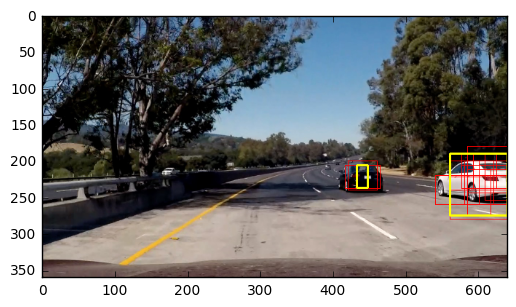

In [331]:
#
# Adding heat maps
#
from scipy.ndimage.measurements import label

def init_heat():
    heatmap = np.zeros((360,640), dtype=np.float32)
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def hot_boxes(labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    return boxes

def candidates(windows):
    heatmap = init_heat()
    add_heat(heatmap, windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    boxes = hot_boxes(labels)
    return boxes

draw_image = np.copy(image)
window_img = draw_boxes(np.copy(image), hot_windows, color=(255, 0, 0), thick=1) 
window_img = draw_boxes(window_img, candidates(hot_windows), color=(255, 255, 0), thick=2)                    
plt.imshow(window_img)

** Dyanmic Heat Maps **

Now we have to pick a "threshold" to pick hot areas for cars.

Statistics to the rescue!

We'll compute the "mean heat" across our image.  We seek to find the hottest areas which, statistically speaking, fall within the 95th percentile.  This is measured as two standard
devations above the mean.

We set our threshold to mean + two standard deviations.  That easy trick seems more than adequate for basic tracking.  We also clip this measure using empirical results for times when the road is cool, i.e., the average heat is low as no vehicles are seen.

We also cool off the heat at a rate of 50% every frame.  We experimented with different values and this seemed to work best.  Higher values (95%) would burn hot areas such as grass and trees, keeping previous spurioius measurements longer than necessary.  Lower values (25%) wouldn't keep good areas around long enough, due to shadows and poor lighting that causes the algorithm to fail intermittently.  50% was a decent compromise.

In [365]:
heat_old = init_heat()

def update_heatmaps(windows):
    global heat_old
    heat_old = add_heat(heat_old*.5, windows)
    m_heat = np.mean(heat_old)
    std_heat = np.std(heat_old)

    # find heat above the 95th percentile, label it
    thresh_hi = max(2.5,(m_heat+2*std_heat))
    heatmap_hi = apply_threshold(np.copy(heat_old), thresh_hi)
    labels_hi = label(heatmap_hi)
    boxes_hi = hot_boxes(labels_hi)
    
    # find heat above the 65th percentile, label it
    thresh_lo = max(2.0,(m_heat+std_heat))
    heatmap_lo = apply_threshold(np.copy(heat_old), thresh_lo)
    labels_lo = label(heatmap_lo)
    boxes_lo = hot_boxes(labels_lo)
    
    # Only retain hot areas in the 95th percentile for the next frame
    apply_threshold(heat_old, thresh_hi) # only keep our hot regions for the next frame
    
    return boxes_lo, thresh_lo, boxes_hi, thresh_hi

def add_status(img, thresh_lo, thresh_hi, cars):
    font = cv2.FONT_HERSHEY_SIMPLEX
    middlepanel = np.zeros((30, 640, 3), dtype=np.uint8)
    status_str = '{} obstacles with threshold [{:.3f}, {:.3f}]'.format(cars, thresh_lo, thresh_hi)
    cv2.putText(middlepanel, status_str, (10, 20), font, 0.6, (255,255,255), 1)
    img[330:360, 0:640] = middlepanel
    
def process_image2(image):
    #
    # Process a single image of driving lanes and store the output
    # in frameN.jpg, where jN is the current frame counter of our global
    # lane test object.
    #
    global windows, svc, X_scaler
    rgb = cv2.resize(image, (640, 360),  interpolation = cv2.INTER_AREA)
    draw_image = np.copy(rgb)
    hot_windows = find_cars(rgb, windows, svc, X_scaler)
    cars_lo, thresh_lo, cars_hi, thresh_hi = update_heatmaps(hot_windows)
    #window_img = draw_boxes(draw_image, hot_windows, color=(255, 255, 255), thick=1)
    window_img = draw_boxes(draw_image, cars_hi, color=(255, 0, 0), thick=3)
    #window_img = draw_boxes(window_img, cars_lo, color=(255, 255, 0), thick=1)
    add_status(window_img, thresh_lo, thresh_hi, len(cars_hi))
    return window_img

def process_video2(input_path, output_path):
    #
    # Process a video at input_path and store the result
    # in output_path.
    #
    global heat_old
    heat_old.fill(0.0)
    clip1 = VideoFileClip(input_path)
    test_clip = clip1.fl_image(process_image2)  
    test_clip.write_videofile(output_path, audio=False)


In [361]:
process_video2(base+"test_video.mp4", "./test_output2.mp4")

[MoviePy] >>>> Building video ./test_output2.mp4
[MoviePy] Writing video ./test_output2.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_output2.mp4 



** Testing Dyanmic Heatmaps **

We run our dynamic heat maps on a short test video.  Looks great!  We have a fast algorithm that quickly identifies the center of cars.  However, our 95% accuracy seems to miss edges of the cars.  That's future work.

In [369]:
%%HTML
<video width="640" height="360" controls>
  <source src="./test_output2.mp4" type="video/mp4">
</video>

** Final Video **

Here we evaluate our dynamic heatmaps on the final, test video.  We do pretty well! 

In [364]:
process_video2(base+"project_video.mp4", "./project_output2.mp4")

[MoviePy] >>>> Building video ./project_output2.mp4
[MoviePy] Writing video ./project_output2.mp4


100%|█████████▉| 1260/1261 [08:18<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output2.mp4 



In [368]:
%%HTML
<video width="640" height="360" controls>
  <source src="./project_output2.mp4" type="video/mp4">
</video>

** Discussion **

We've made significant progress with a computationally cheap algorithm, suitable for running on a low powered processor within a car.  Our 500-ish features can process 5-8 frames per second on a 2014 MacBook Pro.  This is adequate and before pipeline optimization such as calculating HOG values once and sharing results across windows, or moving elements of computation into optimized fucntions in scikit, skimage, cv2 and other libraries.  That's a namespace problem -- keeping track of all those functions!  We leave that to the reader.

This pedagogical example is far from complete for a commercial offering.  The regions identifed by dynamic heatmaps still flicker, and they don't cover the entire bounding box of each vehicle.  We could modify this to use the target area as a focus for a deep, detailed scan of the surrounding region with boxes that heavily overlap.  We do this as humans.  Something catches our eye, then we focus on that item, perusing it in detail.  The algoirthm presented here is the first stage, grabbing our attention.  For that, the technique performs well.

We can improve our tracking of objects with a 3D model. This simple example demonstrates how to cars can intersect, creating a larger, single obstacle.  Only when the cars separate sufficiently do we see they are indeed two separate cars.  However, I'm not sure that's so bad.  Remember Top Gun?  The pilots thought they only had two bogies.  It wasn't until they got close that the bogies separated and equipment identiifed the four separate planes.  We see the same thing happening here to us.

I'd like to explore the use of deep learning as a classifier.  This project focused on hand-engineered histograms of gradients, color histograms, and more.  Deep learning would work directly from pixels to classify image window regions as cars or not.  I felt that applying Deep Learning to HOGs felt wrong -- we were hand engineering techniques that may restrict DL's ability to find correlations among features we have not considered.

Overall, I'm delighted at the chance to explore these techniques as part of the Udacity course.  This really gives us a sense for the issues in identifying cars.  It also continues my interest in Deep Learning as a method for radically simplifying the data pipeline by eliminating hand-engineered features.

_Scott Penberthy_

February 11, 2017




